# Описание действий :
- Нужно разобраться, как ведут себя пользователи мобильного приложения.
- Изучить воронку продаж.
- Узнать, как пользователи доходят до покупки.
- Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.
- Создать две группы A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, то можно быть увереным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов.
- В случае общей аналитики и A/A/B-эксперимента работать с одними и теми же данными.

## Шаг 1. Открыть файл с данными и изучить общую информацию

In [5]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [6]:
df = pd.read_csv('Data/logs_exp.csv',sep='\t')

In [7]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Шаг 2. Подготовить данные
- Заменить названия столбцов на удобные для вас;
- Проверить пропуски и типы данных. Откорректировать, если нужно;
- Добавить столбец даты и времени, а также отдельный столбец дат;

In [8]:
df.columns = ['event','device_id','datetime','group']

### Посмотрел пропуски

In [9]:
df.isna().sum()

event        0
device_id    0
datetime     0
group        0
dtype: int64

### Типы данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   device_id  244126 non-null  int64 
 2   datetime   244126 non-null  int64 
 3   group      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Заменил числовой формат на формат datetime

In [11]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

In [12]:
df.head()

,event,device_id,datetime,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


### Посмотрел полные дупликаты и исключил

In [13]:
df.duplicated().sum()

413

In [14]:
df = df.drop_duplicates()

In [15]:
df.head()

,event,device_id,datetime,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


### Добавил столбец даты

In [16]:
df['date'] = df['datetime'].dt.date

In [17]:
df.head()

,event,device_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Шаг 3. Изучить и проверить данные

- Данными за какой период есть?
- Какой максимальная и минимальная дата.
- Сделать гистограмму по дате и времени.
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

Определить, с какого момента данные полные и отбросить более старые.
- Данные за какой период времени имеются на самом деле?

- Много ли событий и пользователей потеряно, отбросив старые данные?
- Проверить, что есть пользователи из всех трёх экспериментальных групп.

### Подсчёт событий

In [18]:
print('Количество уникальных событий =',df['event'].nunique())

Количество уникальных событий = 5


In [19]:
print('После удаления дубликатов, количество событий =', len(df))

После удаления дубликатов, количество событий = 243713


### Подсчёт пользователей

In [20]:
print('Количество уникальных ползователей =', df['device_id'].nunique())

Количество уникальных ползователей = 7551


### Среднее кол-во событий на пользователя

In [21]:
df.groupby('device_id')['event'].count().reset_index()

,device_id,event
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


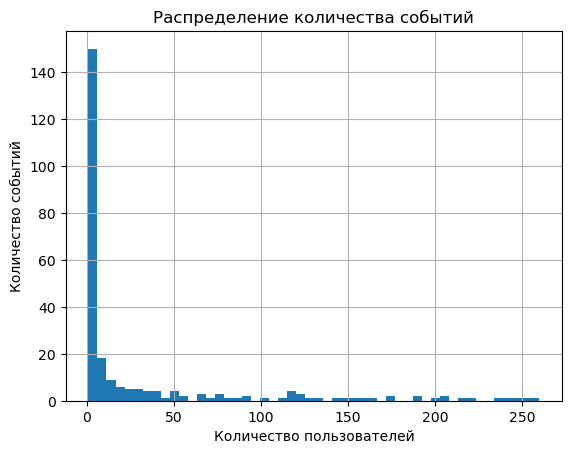

In [22]:
count_events = df.groupby('device_id', as_index=False)['event'].count()
count_events.groupby('event')['device_id'].count().hist(bins = 50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий')
plt.show()

In [23]:
print('Пользователь в среднем совершает', round(len(df)/df['device_id'].nunique()), 'действия')
print('Медиана количества действия =', df.groupby('device_id')['event'].count().median())
print('Мнимальное количество действий =', df.groupby('device_id')['event'].count().min())
print('Максимальное количество действий =', df.groupby('device_id')['event'].count().max())

Пользователь в среднем совершает 32 действия
Медиана количества действия = 20.0
Мнимальное количество действий = 1
Максимальное количество действий = 2307


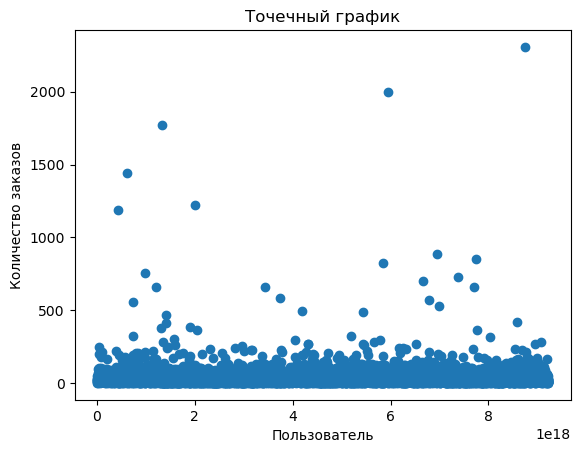

In [24]:
plt.scatter(y=df.groupby('device_id')['event'].count(), x=df['device_id'].unique())
plt.xlabel('Пользователь')
plt.ylabel('Количество заказов')
plt.title('Точечный график')
plt.show()

In [25]:
np.percentile(df.groupby('device_id')['event'].count(), [90,95,96,97,98,99])

array([ 64. ,  89. , 100. , 115.5, 136. , 200.5])

На скатере видно, что очень много невероятно больших выбросов - исключим все значения по 99 перцентиль

In [26]:
not_many = df.groupby('device_id')['event'].count().reset_index()
not_many = not_many[not_many['event'] <= np.percentile(df.groupby('device_id')['event'].count(), 99)]
not_many = not_many.drop(columns='event')

In [27]:
df = df[df['device_id'].isin(not_many['device_id'].unique())]

### Период эксперимента

In [28]:
print('Начало-', min(df['datetime']),'\nКонец-', max(df['datetime']))
print('Временной интервал эксперимента =',max(df['datetime']) - min(df['datetime']))

Начало- 2019-07-25 04:43:36 
Конец- 2019-08-07 21:15:17
Временной интервал эксперимента = 13 days 16:31:41


In [29]:
names_event = df.pivot_table(index = ['event', 'date'], values = ['device_id'], aggfunc='count').reset_index()

In [30]:
names_event['event'].unique()

array(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'], dtype=object)

In [31]:
users_per_day = df.pivot_table(index = 'date', values = 'device_id', aggfunc = 'nunique').reset_index()

### Гистаграма поситителей по датам

In [32]:
CartScreenAppear = names_event[names_event['event'] == 'CartScreenAppear']
MainScreenAppear = names_event[names_event['event'] == 'MainScreenAppear']
OffersScreenAppear = names_event[names_event['event'] == 'OffersScreenAppear']
PaymentScreenSuccessful = names_event[names_event['event'] == 'PaymentScreenSuccessful']
Tutorial = names_event[names_event['event'] == 'Tutorial']

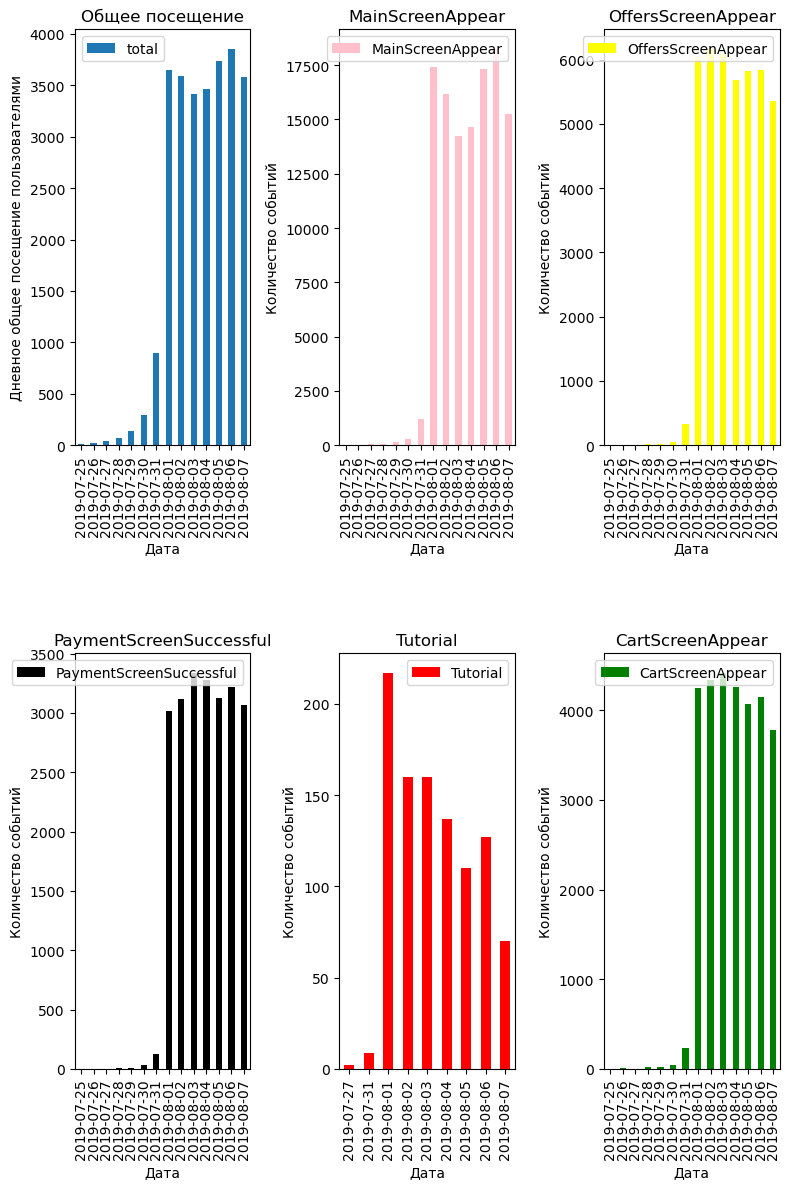

In [33]:
# создание области для рисования с двумя субграфиками
fig, axs = plt.subplots(2, 3, figsize=(8, 12))

ax1 = users_per_day.plot(x='date', y='device_id', ax=axs[0][0], kind='bar', label = 'total')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Дневное общее посещение пользователями')
ax1.set_title('Общее посещение')

ax2 = MainScreenAppear.plot(x='date', y='device_id', ax=axs[0][1], kind='bar', label = 'MainScreenAppear', color='pink')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Количество событий')
ax2.set_title('MainScreenAppear')

ax3 = OffersScreenAppear.plot(x='date', y='device_id', ax=axs[0][2], kind='bar', label = 'OffersScreenAppear', color='yellow')
ax3.set_xlabel('Дата')
ax3.set_ylabel('Количество событий')
ax3.set_title('OffersScreenAppear')

ax4 = PaymentScreenSuccessful.plot(x='date', y='device_id', ax=axs[1][0], kind='bar', label = 'PaymentScreenSuccessful', color='black')
ax4.set_xlabel('Дата')
ax4.set_ylabel('Количество событий')
ax4.set_title('PaymentScreenSuccessful')

ax5 = Tutorial.plot(x='date', y='device_id', ax=axs[1][1], kind='bar', label = 'Tutorial', color='red')
ax5.set_xlabel('Дата')
ax5.set_ylabel('Количество событий')
ax5.set_title('Tutorial')

ax6 = CartScreenAppear.plot(x='date', y='device_id', ax=axs[1][2], kind='bar', label = 'CartScreenAppear', color='green')
ax6.set_xlabel('Дата')
ax6.set_ylabel('Количество событий')
ax6.set_title('CartScreenAppear')

plt.tight_layout()
plt.subplots_adjust(hspace = 0.5)
plt.show()

# Вывод
На всех графиках видно, что основная масса действий происходила после 31 июля.

На основе имеющихся данных, можно сделать вывод, что реально можно оценить всю информацию только с начала августа.

### Создание чистой таблицы

In [34]:
# Созадам копию имеющего датасета
df_copy = df.copy()

In [35]:
# Исключю отсюда пользователей до 1 августа
df_copy = df_copy[df_copy['date'] > pd.to_datetime('2019-07-31')]

D:\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [36]:
# Столько событий выпало
print('Уменьшение количества событий на',len(df) - len(df_copy))
print( 'Уменьшение количества событий в процентах',round((len(df) / len(df_copy) - 1)*100, 3))
print('Количество пользователей выпало =',df['device_id'].nunique() - df_copy['device_id'].nunique())
print('Количество пользователей выпало в процентах =',round((df['device_id'].nunique()/ df_copy['device_id'].nunique()-1)*100, 3))

Уменьшение количества событий на 2718
Уменьшение количества событий в процентах 1.315
Количество пользователей выпало = 17
Количество пользователей выпало в процентах = 0.228


In [37]:
df_copy['group'].unique()

array([246, 247, 248], dtype=int64)

In [38]:
df_copy.groupby('group')['device_id'].nunique()

group
246    2456
247    2491
248    2511
Name: device_id, dtype: int64

In [39]:
old_groups = df.groupby('group')['device_id'].count().reset_index()

In [40]:
old_groups['total'] = len(df)

In [41]:
old_groups['percent'] = old_groups['device_id']/old_groups['total']

In [42]:
new_groups = df_copy.groupby('group')['device_id'].count().reset_index()

In [43]:
new_groups['total'] = len(df_copy)

In [44]:
new_groups['percent'] = new_groups['device_id']/new_groups['total']

In [45]:
display(old_groups.drop(columns = ['device_id', 'total']).T)
new_groups.drop(columns = ['device_id', 'total']).T

,0,1,2
group,246.00000,247.000000,248.000000
percent,0.32604,0.330536,0.343424


,0,1,2
group,246.000000,247.000000,248.000000
percent,0.326269,0.330542,0.343189


# Вывод
Снижение общего количества строк чуть более чем на 1 процент, я думаю, не понесёт серьёзных последствий.

Все группы остались и процентное соотношение практически не изменилось

## Шаг 4. Изучить воронку событий

### Сортировка по частоте в порядке убывания

In [46]:
# Сгруппирую события по частоте
event_groups = df_copy.groupby('event')['device_id'].count().reset_index().sort_values(by='device_id', ascending=False)

In [47]:
# Мы видим, что туториал появляется крайне редко - посчитаю проценты
event_groups['total'] = len(df_copy)
event_groups['percent'] = event_groups['device_id'] / event_groups['total']
event_groups = event_groups.drop(columns = 'total')

In [48]:
event_groups = event_groups.rename(columns = {'device_id':'count'})

In [49]:
event_groups = event_groups.reset_index().drop(columns='index')

In [50]:
event_groups['count'][0]

113264

In [51]:
event_groups['diff_previouse'] = 1 - event_groups['count'] / event_groups['count'].shift()
event_groups['diff_previouse'].iloc[0] = 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_10404\2922386471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_groups['diff_previouse'].iloc[0] = 0


In [52]:
event_groups

,event,count,percent,diff_previouse
0,MainScreenAppear,113264,0.548189,0.000000
1,OffersScreenAppear,40956,0.198224,0.638402
2,CartScreenAppear,29250,0.141568,0.285819
3,PaymentScreenSuccessful,22164,0.107272,0.242256
4,Tutorial,981,0.004748,0.955739


### Просмотр сколько ползователей прошли каждый этап

In [53]:
event_users = df_copy.groupby('event')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)
event_users

,event,device_id
1,MainScreenAppear,7344
2,OffersScreenAppear,4517
0,CartScreenAppear,3658
3,PaymentScreenSuccessful,3463
4,Tutorial,824


In [54]:
event_users = event_users.rename(columns = {'device_id':'count'})
event_users['persents'] = event_users['count'] / df_copy['device_id'].nunique()
event_users['diff_prev'] = 1 - event_users['count'] / event_users['count'].shift()
event_users = event_users.drop(index=4)
event_users = event_users.fillna(0)

In [55]:
df_copy['device_id'].nunique()

7458

In [56]:
event_users
# колонка percent показывает какой процент пользователей хотя бы раз выполнили то или иное действие
# колонка count показывает количество пользователей прошедших событие

,event,count,persents,diff_prev
1,MainScreenAppear,7344,0.984714,0.000000
2,OffersScreenAppear,4517,0.605658,0.384940
0,CartScreenAppear,3658,0.490480,0.190170
3,PaymentScreenSuccessful,3463,0.464334,0.053308


### Если предположить, что все этапы обязательны и последовательны друг за другом, кроме туториала, то необходимо обозначить

### Доля пользователей, у которых какое-либо событие было достигнуто

In [57]:
pd.set_option('display.max_colwidth', None)
events_per_users = df_copy.groupby('device_id')['event'].nunique().reset_index()
events_per_users = events_per_users.groupby('event')['device_id'].count().reset_index().rename(columns={'event':'events', 'device_id':'count'})
df_copy.groupby('device_id')['event'].unique().reset_index().head(20)

,device_id,event
0,6888746892508752,[MainScreenAppear]
1,6909561520679493,"[MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear]"
2,6922444491712477,"[MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear]"
3,7435777799948366,[MainScreenAppear]
4,7702139951469979,"[MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]"
5,8486814028069281,"[OffersScreenAppear, CartScreenAppear, MainScreenAppear]"
6,8740973466195562,"[MainScreenAppear, OffersScreenAppear]"
7,9841258664663090,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]"
8,12692216027168046,"[MainScreenAppear, OffersScreenAppear]"
9,15708180189885246,"[OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, MainScreenAppear]"


Количество пользователей, которые прошли определенное количество уникальных событий:

ЛЕГЕНДА (указано последние событие по воронке)
Количество уникальных пользователей = 7458
                        0                   1                 2  \
events   MainScreenAppear  OffersScreenAppear  CartScreenAppear   
count                2717                1004               317   
percent         36.430678           13.462054          4.250469   

                               3         4  
events   PaymentScreenSuccessful  Tutorial  
count                       2970       450  
percent                39.823009  6.033789  


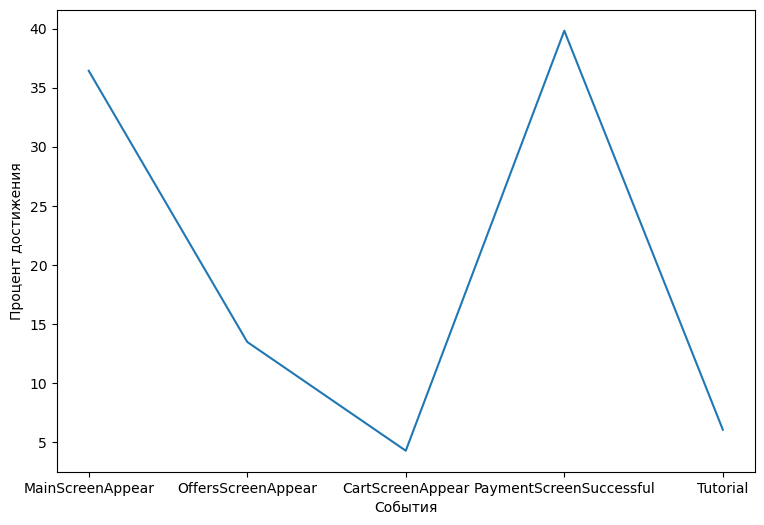

In [58]:
events_per_users = df_copy.groupby('device_id')['event'].nunique().reset_index()
events_per_users = events_per_users.groupby('event')['device_id'].count().reset_index().rename(columns={'event':'events', 'device_id':'count'})
sum_count = sum(events_per_users['count'])
events_per_users['percent'] = events_per_users['count'] / sum_count * 100
events_per_users['events'] = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful', 'Tutorial']

print('Количество пользователей, которые прошли определенное количество уникальных событий:\n')
print('ЛЕГЕНДА (указано последние событие по воронке)')
print(f'Количество уникальных пользователей = {sum_count}\n{events_per_users.T}')

plt.figure(figsize=(9,6))
plt.plot(events_per_users['events'],events_per_users['percent'])
plt.xlabel('События')
plt.ylabel('Процент достижения')
plt.show()

- Tutorial: Пользователь сначала может проходить обучение или руководство по использованию приложения. Этот шаг не всегда является обязательным и может быть пропущен некоторыми пользователями.

- MainScreenAppear: После или вместо обучения пользователь переходит на главный экран приложения, где он может просмотреть доступные продукты или категории продуктов.

- OffersScreenAppear: Затем пользователь может перейти к экрану с предложениями или выбрать конкретный продукт для просмотра деталей.

- CartScreenAppear: После выбора товаров пользователь переходит в корзину, где может просмотреть свой выбор и подтвердить намерение совершить покупку.

- PaymentScreenSuccessful: Наконец, пользователь переходит к экрану оплаты, где он вводит свои данные для оплаты. Успешное завершение этого этапа означает, что покупка была совершена успешно.

In [59]:
event_users

,event,count,persents,diff_prev
1,MainScreenAppear,7344,0.984714,0.000000
2,OffersScreenAppear,4517,0.605658,0.384940
0,CartScreenAppear,3658,0.490480,0.190170
3,PaymentScreenSuccessful,3463,0.464334,0.053308


#### A - MainScreenAppear
#### B - OffersScreenAppear
#### C - CartScreenAppear
#### D - PaymentScreenSuccessful

До оплаты дошло ~40% пользователей.

# Вывод
Видна логика - сначала главный экран => страница с предложениями => содержание корзины => выполненная оплата.
Однако есть ещё одно событие под названием туториал. Могу предположить, что это необязательное событие для выполнения логики.

БОльшие потери идут на этапе А-В ~ 38%, затем B-C ~ 19%, C-D ~ 5 %.

До оплаты доходит 46% пользователей.

## Шаг 5. Изучить результаты эксперимента

- Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

- Какой уровень значимости выбрал при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?

### Сколько пользователей в каждой экспериментальной группе?

In [60]:
df_copy.groupby('group')['device_id'].nunique().reset_index()

,group,device_id
0,246,2456
1,247,2491
2,248,2511


In [61]:
df_copy.groupby('device_id')['group'].nunique().reset_index().sort_values(by='group', ascending=False)

,device_id,group
0,6888746892508752,1
4967,6207091767962101846,1
4979,6217295124800833842,1
4978,6216080220799726690,1
4977,6215559225876063378,1
...,...,...
2482,3171891164497446149,1
2481,3171454373076660766,1
2480,3170212200647575044,1
2479,3167974726645136146,1


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Если мы хотим определить, есть ли значимая разница между долей пользователей, совершивших определенное действие, в двух разных экспериментальных группах, мы можем использовать z-test для оценки равенства пропорций

H0 - группы идентичны и пропорции имеют высокую схожесть

Н1 - группы неидентичны и пропорции низкую степень схожести

альфа = 0.05

In [62]:
alpha = .05

In [63]:
a = df_copy[df_copy['event'] == 'PaymentScreenSuccessful'].groupby('group')['device_id'].nunique().reset_index()
a[a['group']==246]['device_id']

0    1172
Name: device_id, dtype: int64

In [64]:
df[df['event'] == 'PaymentScreenSuccessful'].groupby('group')['device_id'].nunique()

group
246    1174
247    1138
248    1159
Name: device_id, dtype: int64

In [65]:
successes = df_copy[df_copy['event'] == 'PaymentScreenSuccessful'].groupby('group')['device_id'].nunique()

totals = df_copy.groupby('group')['device_id'].nunique()

successes_array = [successes[246], successes[247]]
totals_array = [totals[246], totals[247]]

zstat, pval = proportions_ztest(successes_array, totals_array)

print('z-statistic:', zstat)
print('p-value:', pval)

if pval < alpha:
    print('Отклоняем нулевую гипотезу: между группами есть статистически значимые различия')
else:
    print('Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными')

z-statistic: 1.4913768456314167
p-value: 0.13586258367273996
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными


# Вывод
На основании z-test можно сделать вывод о том, что группы имеют разные пропорции

### Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [66]:
group246 = df_copy[(df_copy['group'] == 246)]
group247 = df_copy[(df_copy['group'] == 247)]
group248 = df_copy[(df_copy['group'] == 248)]

In [67]:
piv246 = group246.pivot_table(index = 'event', values = 'device_id', aggfunc = 'nunique').reset_index().sort_values(by='device_id',ascending = False)
piv246['total'] = df_copy[(df_copy['group'] == 246)]['device_id'].nunique()
piv246['percente'] = round(piv246['device_id'] / piv246['total'], 3)
piv246

,event,device_id,total,percente
1,MainScreenAppear,2423,2456,0.987
2,OffersScreenAppear,1514,2456,0.616
0,CartScreenAppear,1238,2456,0.504
3,PaymentScreenSuccessful,1172,2456,0.477
4,Tutorial,269,2456,0.110


In [68]:
piv247 = group247.pivot_table(index = 'event', values = 'device_id', aggfunc = 'nunique').reset_index().sort_values(by='device_id',ascending = False)
piv247['total'] = df_copy[(df_copy['group'] == 247)]['device_id'].nunique()
piv247['percente'] = round(piv247['device_id'] / piv247['total'], 3)
piv247

,event,device_id,total,percente
1,MainScreenAppear,2454,2491,0.985
2,OffersScreenAppear,1498,2491,0.601
0,CartScreenAppear,1216,2491,0.488
3,PaymentScreenSuccessful,1136,2491,0.456
4,Tutorial,279,2491,0.112


In [69]:
users_246 = df_copy[df_copy['group'] == 246]['device_id'].nunique()
users_247 = df_copy[df_copy['group'] == 247]['device_id'].nunique()

for event in df_copy['event'].unique():
    event_users_246 = df_copy[(df_copy['group'] == 246) & (df_copy['event'] == event)]['device_id'].nunique()
    event_users_247 = df_copy[(df_copy['group'] == 247) & (df_copy['event'] == event)]['device_id'].nunique()

    stat, p = proportions_ztest([event_users_246, event_users_247], [users_246, users_247])

    print(f"Для события {event}, p-value = {p}.")

    print(f"H0 - статзначимость есть среди события {event} групп 246 и 247")
    if p < alpha:
        print('Отклоняем нулевую гепотезу')
    else:
        print('Не отклоняем нулевую')
    print(f'Доля пользователей из 246, которые прошли {event} =',(df_copy[(df_copy['group'] == 246)]['event'] == event).mean())
    print(f'Доля пользователей из 247, которые прошли {event} =',(df_copy[(df_copy['group'] == 247)]['event'] == event).mean())
    print()

Для события Tutorial, p-value = 0.7814899141660463.
H0 - статзначимость есть среди события Tutorial групп 246 и 247
Не отклоняем нулевую
Доля пользователей из 246, которые прошли Tutorial = 0.004524417017741649
Доля пользователей из 247, которые прошли Tutorial = 0.004831978915001098

Для события MainScreenAppear, p-value = 0.6730951807208486.
H0 - статзначимость есть среди события MainScreenAppear групп 246 и 247
Не отклоняем нулевую
Доля пользователей из 246, которые прошли MainScreenAppear = 0.5352459502759153
Доля пользователей из 247, которые прошли MainScreenAppear = 0.5539937037850502

Для события OffersScreenAppear, p-value = 0.27702771700769824.
H0 - статзначимость есть среди события OffersScreenAppear групп 246 и 247
Не отклоняем нулевую
Доля пользователей из 246, которые прошли OffersScreenAppear = 0.19680472319468345
Доля пользователей из 247, которые прошли OffersScreenAppear = 0.1979061424701662

Для события CartScreenAppear, p-value = 0.26299626637167794.
H0 - статзначим

# Вывод
Группировки по событиям разбиты корректно - подтверждение предыдущему выводу

### Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [70]:
users_246 = df_copy[df_copy['group'] == 246]['device_id'].nunique()
users_248 = df_copy[df_copy['group'] == 248]['device_id'].nunique()

for event in df_copy['event'].unique():
    event_users_246 = df_copy[(df_copy['group'] == 246) & (df_copy['event'] == event)]['device_id'].nunique()
    event_users_248 = df_copy[(df_copy['group'] == 248) & (df_copy['event'] == event)]['device_id'].nunique()

    stat, p = proportions_ztest([event_users_246, event_users_248], [users_246, users_248])

    print(f"Для события {event}, p-value = {p}.")

    print(f"H0 - статзначимость есть среди события {event} групп 246 и 248")
    if p < alpha:
        print('Отклоняем нулевую гепотезу, статистически значимые различия между долями пользователей есть')
    else:
        print('Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.')
    print(f'Доля пользователей из 246, которые прошли {event} =',(df_copy[(df_copy['group'] == 246)]['event'] == event).mean())
    print(f'Доля пользователей из 248, которые прошли {event} =',(df_copy[(df_copy['group'] == 248)]['event'] == event).mean())
    print()

Для события Tutorial, p-value = 0.965048079100338.
H0 - статзначимость есть среди события Tutorial групп 246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246, которые прошли Tutorial = 0.004524417017741649
Доля пользователей из 248, которые прошли Tutorial = 0.004879562249675636

Для события MainScreenAppear, p-value = 0.24380010740478963.
H0 - статзначимость есть среди события MainScreenAppear групп 246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246, которые прошли MainScreenAppear = 0.5352459502759153
Доля пользователей из 248, которые прошли MainScreenAppear = 0.5549021266993851

Для события OffersScreenAppear, p-value = 0.21751867407994285.
H0 - статзначимость есть среди события OffersScreenAppear групп 246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246, которые прошли Offer

# Вывод
Как и прежде, между 246 и 248 нет статистически значимых различий

In [71]:
users_247 = df_copy[df_copy['group'] == 247]['device_id'].nunique()
users_248 = df_copy[df_copy['group'] == 248]['device_id'].nunique()

for event in df_copy['event'].unique():
    event_users_247 = df_copy[(df_copy['group'] == 247) & (df_copy['event'] == event)]['device_id'].nunique()
    event_users_248 = df_copy[(df_copy['group'] == 248) & (df_copy['event'] == event)]['device_id'].nunique()

    stat, p = proportions_ztest([event_users_247, event_users_248], [users_247, users_248])

    print(f"Для события {event}, p-value = {p}.")

    print(f"H0 - статзначимость есть среди события {event} групп 247 и 248")
    if p < alpha:
        print('Отклоняем нулевую гепотезу, статистически значимые различия между долями пользователей есть')
    else:
        print('Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.')
    print(f'Доля пользователей из 247, которые прошли {event} =',(df_copy[(df_copy['group'] == 247)]['event'] == event).mean())
    print(f'Доля пользователей из 248, которые прошли {event} =',(df_copy[(df_copy['group'] == 248)]['event'] == event).mean())
    print()

Для события Tutorial, p-value = 0.8142406312184222.
H0 - статзначимость есть среди события Tutorial групп 247 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 247, которые прошли Tutorial = 0.004831978915001098
Доля пользователей из 248, которые прошли Tutorial = 0.004879562249675636

Для события MainScreenAppear, p-value = 0.45453362307563017.
H0 - статзначимость есть среди события MainScreenAppear групп 247 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 247, которые прошли MainScreenAppear = 0.5539937037850502
Доля пользователей из 248, которые прошли MainScreenAppear = 0.5549021266993851

Для события OffersScreenAppear, p-value = 0.885074626949582.
H0 - статзначимость есть среди события OffersScreenAppear групп 247 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 247, которые прошли Offers

# Вывод
Между 247 и 248 нет статистически значимые различий

In [72]:
control_groups = df_copy[df_copy['group'].isin([246, 247])]
group_248 = df_copy[df_copy['group'] == 248]

control_group_users = control_groups['device_id'].nunique()
users_248 = group_248['device_id'].nunique()

for event in df_copy['event'].unique():
    control_event_users = control_groups[control_groups['event'] == event]['device_id'].nunique()
    event_users_248 = group_248[group_248['event'] == event]['device_id'].nunique()

    stat, p = proportions_ztest([control_event_users, event_users_248], [control_group_users, users_248])

    print(f"Для события {event}, p-value = {p}.")

    print(f"H0 - статзначимость есть среди события {event} групп 247+246 и 248")
    if p < alpha:
        print('Отклоняем нулевую гепотезу, статистически значимые различия между долями пользователей есть')
    else:
        print('Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.')
    print(f'Доля пользователей из 246+247, которые прошли {event} =',(control_groups['event'] == event).mean())
    print(f'Доля пользователей из 248, которые прошли {event} =',(group_248['event'] == event).mean())
    print()

Для события Tutorial, p-value = 0.9110803298208449.
H0 - статзначимость есть среди события Tutorial групп 247+246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246+247, которые прошли Tutorial = 0.004679198567502045
Доля пользователей из 248, которые прошли Tutorial = 0.004879562249675636

Для события MainScreenAppear, p-value = 0.26186402859555846.
H0 - статзначимость есть среди события MainScreenAppear групп 247+246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246+247, которые прошли MainScreenAppear = 0.5446808197071632
Доля пользователей из 248, которые прошли MainScreenAppear = 0.5549021266993851

Для события OffersScreenAppear, p-value = 0.4280183471214126.
H0 - статзначимость есть среди события OffersScreenAppear групп 247+246 и 248
Не отклоняем нулевую, статистически значимых различий между долями пользователей нет.
Доля пользователей из 246+2

# Вывод
На основании активности пользователей трёх групп можно сделать, можно сделать вывод, что эффективность конверсии группы 248 не имеет статзначимости во всех случаях при сравнении с группами 246 и 247

### Какой уровень значимости выбрал при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?

In [73]:
num_tests = len(df_copy['event'].unique()) * 4
alpha = 0.05
alpha_adjusted = alpha / num_tests
alpha_adjusted

0.0025

In [74]:
num_tests = len(df_copy['event'].unique()) * 3
alpha = 0.05
alpha_adjusted = alpha / num_tests


groups = [(group246, '246'), (group247, '247'), (control_groups, '246+247')]

for group, group_name in groups:
    print(f"Сравнение группы 248 с группой {group_name}")
    for event in df_copy['event'].unique():
        event_users_control = group[group['event'] == event]['device_id'].nunique()
        event_users_248 = group248[group248['event'] == event]['device_id'].nunique()

        total_users_control = group['device_id'].nunique()
        total_users_248 = group248['device_id'].nunique()

        stat, p = proportions_ztest([event_users_control, event_users_248], [total_users_control, total_users_248])

        print(f"Для события {event}, p-value = {p:.4f}.")
        if p < alpha_adjusted:
            print('Отклоняем нулевую гипотезу: между группами есть статистически значимые различия')
        else:
            print('Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными')
    print()


Сравнение группы 248 с группой 246
Для события Tutorial, p-value = 0.9650.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события MainScreenAppear, p-value = 0.2438.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события OffersScreenAppear, p-value = 0.2175.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события CartScreenAppear, p-value = 0.0832.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события PaymentScreenSuccessful, p-value = 0.2239.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными

Сравнение группы 248 с группой 247
Для события Tutorial, p-value = 0.8142.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события MainScreenAppear, p-value = 0.4545.
Не получилось отклонить нулевую гипотезу, нет оснований считать группы разными
Для события OffersScreenAppear, p-value = 0.885

# Вывод
Я использовал уровень статзначимости = 0,05. Однако было проведено 20 тестов - это значит, что при вероятность получения хотя бы одного ложного положительного результата увеличивается. Поэтому я уменьшил уровень в 20 раз, но результаты не изменились.

# Общий вывод
По итогу исследования, можно сказать, что эффекта от смены шрифта нет.